# Strategic Research: Optimized Passive Exposure via Oracle Sector Rotation

## 1. Introduction: The Passive Investor's Dilemma

### Exercise Objective

As an equity investor, you operate under the Efficient Market Hypothesis (EMH), which suggests that consistently beating the market is impossible without insider information. Consequently, your baseline strategy is passive indexing.

However, this exercise explores a "What-If" scenario: Can we optimize passive exposure by navigating market regimes more effectively than simple Dollar-Cost-Averaging (DCA)? We aim to determine the "ideal" systematic exposure (Beta) at any given time using a universe of six factor-based ETFs. By utilizing an Oracle Approach (hindsight-driven optimization), we establish a theoretical performance ceiling. This benchmark reveals how much value lies in perfectly timing the transition between aggressive and defensive equity factors.

The Investable Universe
To ensure we are testing active sector rotation rather than just holding the market, we exclude the benchmark (SPY) from our holdings. The portfolio must choose between:

- IJS: Small-Cap Value (High Beta/Size Factor)

- QQQ: Nasdaq 100 (Technology/Growth Factor)

- XLF: Financials (Cyclical/Interest Rate Sensitivity)

- XLE: Energy (Inflation/Commodity Proxy)

- XLV: Health Care (Defensive/Quality)

- XLU: Utilities (Low Beta/Defensive)

In [2]:
# Load the libraries
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
# We use ETFs that have history going back to ~2000 or close to it.
# SPY (Market), IJS (Small Value - High Beta proxy), USMV (Low Vol - Low Beta proxy), 
# MTUM (Momentum - though history is shorter, we can use VIG as a Quality/Staple proxy for older data)
tickers = ['SPY', 'IJS', 'XLV', 'XLU', 'QQQ', 'XLE', 'XLF'] 
benchmark = 'SPY'
assets = ['IJS', 'XLV', 'XLU', 'QQQ', 'XLE', 'XLF'] 
# Note: Real MSCI data would be better, but these capture the beta spread (Utilities vs Tech vs Energy).

In [5]:
# Let's load the datasets using yfinance
# We would normally use the 2000 to 2020 as our observation period and 2020 to 2024 as our testing period 
start_date = "2000-01-01"
end_date = "2024-12-31"
data = yf.download(tickers, start=start_date, end=end_date)
returns = data['Close'].pct_change().dropna()
returns

[*********************100%***********************]  7 of 7 completed


Ticker,IJS,QQQ,SPY,XLE,XLF,XLU,XLV
Date,,,,,,,
2000-07-31,0.006989,0.029497,0.006378,-0.006383,0.017220,0.002831,0.009751
2000-08-01,0.013882,-0.013278,0.006119,0.018736,0.006650,0.022022,0.008583
2000-08-02,0.007075,-0.017705,0.004996,0.018918,-0.001201,0.016574,0.004256
2000-08-03,-0.006119,0.043258,0.006916,-0.013925,0.026458,0.001631,0.005296
2000-08-04,0.005928,-0.003456,0.005365,0.004184,0.038665,-0.005426,0.020548
...,...,...,...,...,...,...,...
2024-12-23,-0.002297,0.009743,0.005988,0.005873,0.002401,0.003404,0.009987
2024-12-24,0.007182,0.013560,0.011115,0.008459,0.011772,0.005522,0.004108
2024-12-26,0.007405,-0.000679,0.000067,-0.000827,0.002449,-0.002354,0.002010


## 2. Methodology: The Oracle Mechanism

### The Optimization Framework

The backtest operates on a Quarterly Rebalancing schedule using two distinct temporal windows:
- Hindsight Optimization (The Future): At the start of each quarter, the "Oracle" looks exactly 63 trading days into the future. It calculates the Maximum Sharpe Ratio weights—identifying the exact mix of the six ETFs that would have produced the best risk-adjusted return for the upcoming period.
- Risk Context (The Past): While the weights are chosen based on the future, the Portfolio Beta is calculated using the previous 252 days (1 year) of historical data relative to SPY. This tells us the systematic risk profile the investor "accepted" when entering that regime.

### Constraints & AssumptionsLong-Only: 
- For simplicity and exercise purposes, no short-selling or leverage is permitted ($0 \le w_i \le 1$).
- Fully Invested: The sum of weights must equal 100% at all times.
- No Market Proxy: The portfolio cannot hold SPY; it must express its market view through the six style/sector factors.

In [6]:
# 2. OPTIMIZATION FUNCTION (Strictly for Assets, excluding SPY)
def get_optimal_portfolio(ret_window, assets_list, rf=0.03/252):
    num_assets = len(assets_list)
    # Only use the asset columns for optimization
    subset = ret_window[assets_list]
    mean_ret = subset.mean()
    cov_matrix = subset.cov()
    
    def neg_sharpe(weights, m_ret, c_mat, r_f):
        p_ret = np.sum(m_ret * weights) * 252
        p_vol = np.sqrt(np.dot(weights.T, np.dot(c_mat, weights))) * np.sqrt(252)
        return -(p_ret - r_f) / p_vol

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    init_guess = num_assets * [1. / num_assets]
    result = sco.minimize(neg_sharpe, init_guess, args=(mean_ret, cov_matrix, rf),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# 3. THE ORACLE LOOP (Forward Optimization, Backward Beta)
results = []
panel_data = []
step_size = 63  # Quarterly
beta_lookback = 252 # 1-Year

for i in range(beta_lookback, len(returns) - step_size, step_size):
    # A. Optimize based on the FUTURE 3 months
    future_window = returns.iloc[i : i + step_size]
    opt_weights = get_optimal_portfolio(future_window, assets)
    
    # B. Calculate Beta of these assets vs SPY using the PAST 1 year
    past_window = returns.iloc[i - beta_lookback : i]
    mkt_var = past_window[benchmark].var()
    
    asset_betas = []
    for a in assets:
        cov = past_window[a].cov(past_window[benchmark])
        asset_betas.append(cov / mkt_var)
    
    # Portfolio Beta is weighted average of component betas
    portfolio_beta = np.dot(opt_weights, asset_betas)
    
    # C. Store for Visuals and Panel CSV
    q_start_date = returns.index[i]
    
    # For CSV/Panel
    weight_dict = dict(zip(assets, opt_weights))
    weight_dict['Date'] = q_start_date
    weight_dict['Portfolio_Beta'] = portfolio_beta
    panel_data.append(weight_dict)
    
    # For Plotting (Daily granularity staircase)
    for j in range(step_size):
        results.append({'Date': returns.index[i+j], 'Oracle_Beta': portfolio_beta})

# Convert to DataFrames
oracle_df = pd.DataFrame(results).set_index('Date')
panel_df = pd.DataFrame(panel_data).melt(id_vars=['Date', 'Portfolio_Beta'], var_name='Asset', value_name='Weight')

In [7]:
# 4. EXPORT our Panel Data to CSV for better visualization
panel_df.to_csv("oracle_rotation_panel.csv", index=False)
print("CSV Exported: oracle_rotation_panel.csv")

CSV Exported: oracle_rotation_panel.csv


## 3. Visualizing Systematic Exposure (Beta)
This section analyzes the "Staircase" of systematic risk.

### Key Questions for Analysis:

- Did the Oracle successfully lower the Beta (de-risk) before the shaded Recession Windows?
- How volatile is the "Ideal Beta"? Does it stay near 1.0, or does it swing wildly between 0.5 (Defensive) and 1.5 (Aggressive)?

[*********************100%***********************]  1 of 1 completed


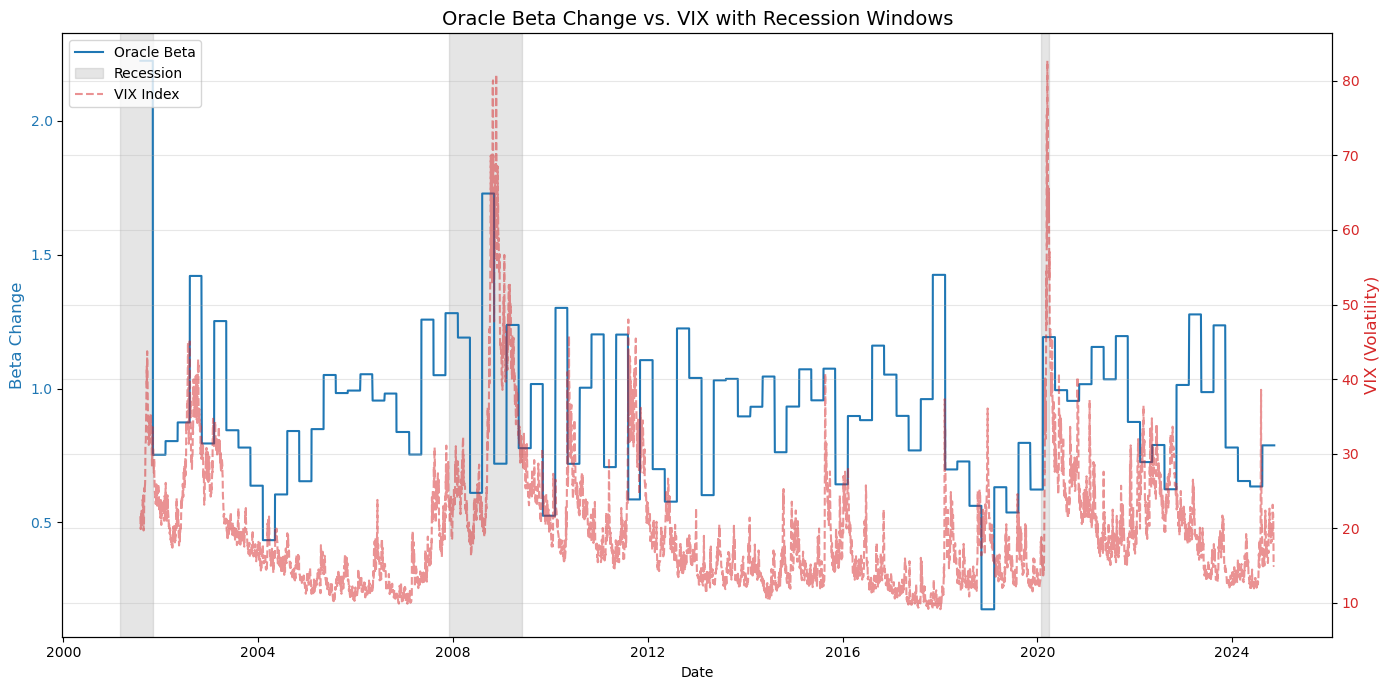

In [8]:
#------------ Let's plot our Beta agaist VIX and recesion windows -------------
# VIX data 
vix_df = yf.download("^VIX", start=oracle_df.index.min(), end=oracle_df.index.max())['Close']

# NBER Recession Dates
recessions = [
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01')
]

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Oracle Beta (Primary Axis)
ax1.plot(oracle_df.index, oracle_df['Oracle_Beta'], color='tab:blue', label='Oracle Beta', linewidth=1.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Beta Change', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary axis for VIX
ax2 = ax1.twinx()
ax2.plot(vix_df.index, vix_df, color='tab:red', label='VIX Index', alpha=0.5, linestyle='--')
ax2.set_ylabel('VIX (Volatility)', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

# 3. Add Recession Windows (Shaded Areas)
for start, end in recessions:
    # Only shade if the recession falls within the dataframe's date range
    if pd.to_datetime(start) >= oracle_df.index.min() or pd.to_datetime(end) <= oracle_df.index.max():
        ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.2, label='Recession' if start == '2007-12-01' else "")

plt.title('Oracle Beta Change vs. VIX with Recession Windows', fontsize=14)


# Handle Legends (Combining both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Mechanics of Rotation (Portfolio Weights)
This section examines the "Engine Room" of the strategy.

### Strategic Observations:

- Regime Concentration: Identify periods where the Oracle "bet the house" on a single factor (e.g., Tech in 2020 or Energy in 2022).
- Factor Cycling: Observe the transition from Growth (QQQ) to Defensive (XLU/XLV) sectors as market conditions shifted.

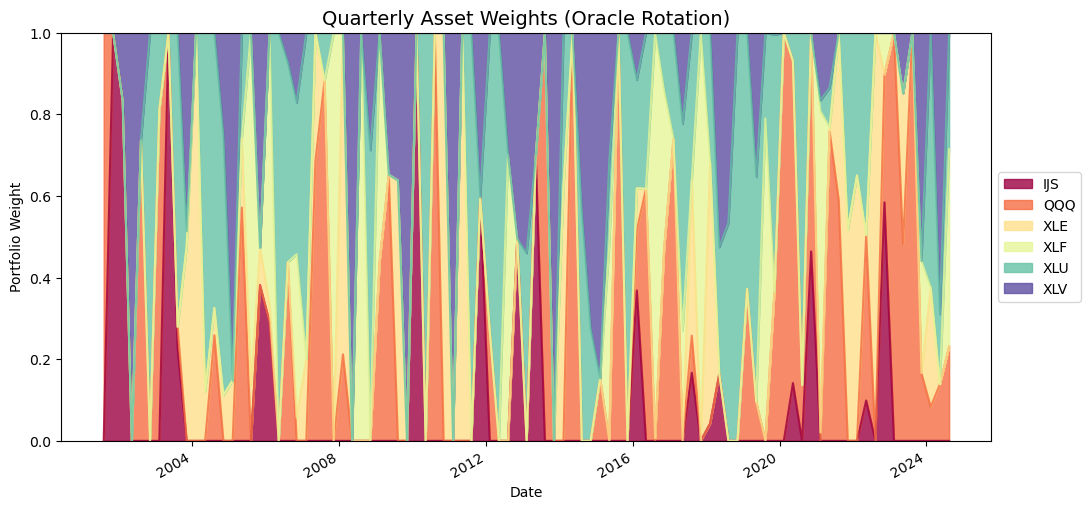

In [9]:
# 1. Pivot quarterly weights to wide format
weights_wide_q = panel_df.pivot(index='Date', columns='Asset', values='Weight')

# --- Plot 2: Sector Allocation (Stacked Area) ---
plt.figure(figsize=(12, 6))
weights_wide_q.plot.area(stacked=True, colormap='Spectral', alpha=0.8, ax=plt.gca())
plt.title('Quarterly Asset Weights (Oracle Rotation)', fontsize=14)
plt.ylabel('Portfolio Weight')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0, 1)
plt.show()

## 5. The Value of Information ($1,000 Growth)
The final comparison: Passive Buy-and-Hold vs. Oracle Rotation.

### Performance Attribution
The green line represents the Theoretical Maximum Efficiency of your factor-based passive exposure. The gap between the Oracle and the Benchmark (SPY) represents the "Alpha" that was available if an investor could perfectly identify the shifting dynamics of market regimes.

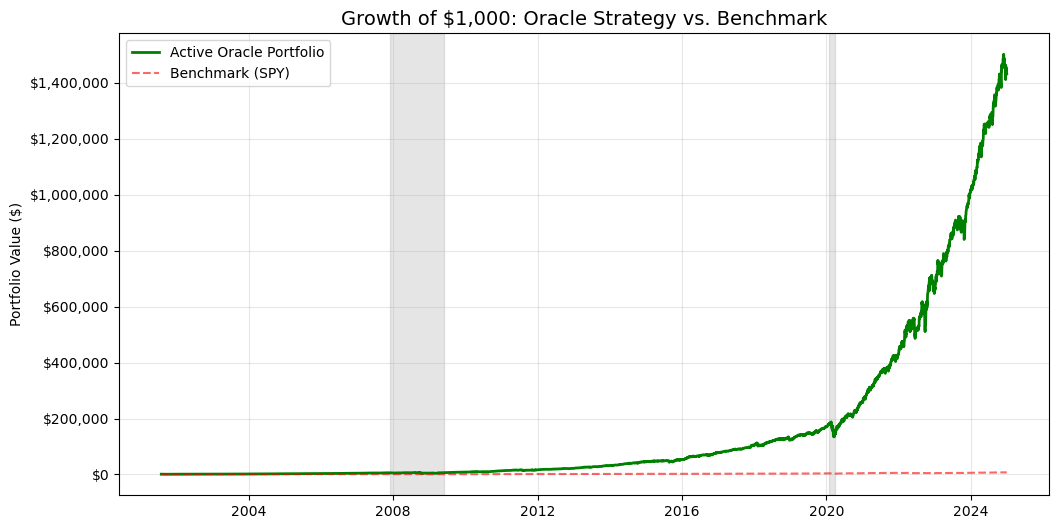

In [10]:
# 2. Expand weights to daily frequency (forward fill across the quarter)
daily_weights = weights_wide_q.reindex(returns.index).ffill().dropna()

# 3. Align asset returns to the dates where we have weights
aligned_asset_returns = returns[assets].loc[daily_weights.index]

# 4. Calculate daily portfolio return: Sum of (Weight * AssetReturn)
oracle_daily_rets = (daily_weights * aligned_asset_returns).sum(axis=1)

# 5. Calculate Cumulative Growth of $1000
start_val = 1000
oracle_cumulative = start_val * (1 + oracle_daily_rets).cumprod()

# 6. Calculate Benchmark Growth over same period
aligned_spy_returns = returns[benchmark].loc[oracle_daily_rets.index]
benchmark_cumulative = start_val * (1 + aligned_spy_returns).cumprod()

# --- Plot 3: Performance Comparison ($1000 Growth) ---
# Calculate returns
daily_w = weights_wide_q.reindex(returns.index).ffill().dropna()
port_rets = (daily_w * returns[assets].loc[daily_w.index]).sum(axis=1)
spy_rets = returns[benchmark].loc[port_rets.index]

# Growth curves
oracle_growth = 1000 * (1 + port_rets).cumprod()
spy_growth = 1000 * (1 + spy_rets).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(oracle_growth, label='Active Oracle Portfolio', color='green', linewidth=2)
plt.plot(spy_growth, label='Benchmark (SPY)', color='red', linestyle='--', alpha=0.6)

for start, end in recessions:
    if pd.to_datetime(start) > oracle_growth.index.min():
        plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.2)

plt.title('Growth of $1,000: Oracle Strategy vs. Benchmark', fontsize=14)
plt.ylabel('Portfolio Value ($)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Statistics & Performance Metrics 

### Evaluating the "Oracle" Efficiency
To quantify the success of this exercise, we look beyond absolute returns and focus on three key institutional metrics:
- Sharpe Ratio ($SR$): Measures excess return per unit of total risk (volatility). A higher Sharpe ratio for the Oracle vs. the Benchmark indicates that hindsight-driven rotation significantly improved the risk-reward profile.
- Information Ratio ($IR$): This is the "Manager's Metric." It measures the strategy's ability to generate excess returns relative to the benchmark (Active Return) divided by the consistency of that excess return (Tracking Error).$$IR = \frac{\text{Annualized Active Return}}{\text{Annualized Tracking Error}}$$
- Systematic Exposure (Beta) Range: We analyze the dispersion of the Oracle Beta to see how "active" the investor needed to be. A wide range (e.g., 0.5 to 1.5) suggests that the optimal strategy required aggressive pivoting between defensive and high-beta regimes.

In [14]:
# 6. STATISTICAL ANALYSIS & RISK METRICS

# Risk-Free Rate (Annualized)
annual_rf = 0.03 
daily_rf = annual_rf / 252

# 1. Calculate Annualized Returns
annual_ret_oracle = port_rets.mean() * 252
annual_ret_spy = spy_rets.mean() * 252

# 2. Calculate Annualized Volatility
annual_vol_oracle = port_rets.std() * np.sqrt(252)
annual_vol_spy = spy_rets.std() * np.sqrt(252)

# 3. Sharpe Ratios
sharpe_oracle = (annual_ret_oracle - annual_rf) / annual_vol_oracle
sharpe_spy = (annual_ret_spy - annual_rf) / annual_vol_spy

# 4. Information Ratio (IR)
active_return = port_rets - spy_rets
annual_active_ret = active_return.mean() * 252
tracking_error = active_return.std() * np.sqrt(252)
information_ratio = annual_active_ret / tracking_error

# --- The 'Oracle' History & Summary Statistics ---
print("="*40)
print("   STATISTICS OF THE BETA OPTIMIZATION   ")
print("="*40)
print("--- The 'Oracle' History ---")
print(oracle_df.head())
print("-" * 40)

# Beta Stats
print(f"Min Optimal Beta:     {oracle_df['Oracle_Beta'].min():.2f}")
print(f"Max Optimal Beta:     {oracle_df['Oracle_Beta'].max():.2f}")
print(f"Avg Optimal Beta:     {oracle_df['Oracle_Beta'].mean():.2f}")
print("-" * 40)

# Performance Table
stats_data = {
    'Metric': ['Annualized Return', 'Annualized Vol', 'Sharpe Ratio'],
    'Oracle Strategy': [f"{annual_ret_oracle:.2%}", f"{annual_vol_oracle:.2%}", f"{sharpe_oracle:.2f}"],
    'Benchmark (SPY)': [f"{annual_ret_spy:.2%}", f"{annual_vol_spy:.2%}", f"{sharpe_spy:.2f}"]
}
stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False))

print("-" * 40)
print(f"Annualized Tracking Error: {tracking_error:.2%}")
print(f"Information Ratio (IR):    {information_ratio:.2f}")
print("="*40)

   STATISTICS OF THE BETA OPTIMIZATION   
--- The 'Oracle' History ---
            Oracle_Beta
Date                   
2001-07-31     2.224806
2001-08-01     2.224806
2001-08-02     2.224806
2001-08-03     2.224806
2001-08-06     2.224806
----------------------------------------
Min Optimal Beta:     0.18
Max Optimal Beta:     2.22
Avg Optimal Beta:     0.92
----------------------------------------
           Metric Oracle Strategy Benchmark (SPY)
Annualized Return          33.57%          10.45%
   Annualized Vol          22.18%          19.09%
     Sharpe Ratio            1.38            0.39
----------------------------------------
Annualized Tracking Error: 13.37%
Information Ratio (IR):    1.73
